In [1]:
import os
import re

import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None


from nlp.utils import get_database, niave_long_to_short_name, get_knowledge_base_from_value_chain_data
from nlp import get_configs_path, get_data_path

In [2]:
def get_ol_dict(df_target, target_entities, train_entities):
    # For those entities which overlap between train and target set, count how often they appear in the target set
    ol_counter = {}
    for entity in target_entities.entity:
        if entity in list(train_entities.entity):
            occurence = len(df_target[df_target.pair.astype(str).str.contains(entity)])
            ol_counter[entity] = occurence 
        else: ol_counter[entity] = 0

    cumsum_df = pd.DataFrame(pd.Series(ol_counter.values()).value_counts()).reset_index().sort_values(by='index').rename(columns = {0: 'occ'})
    cumsum_df['cumsum_occ'] = np.cumsum(cumsum_df.occ)  / len(target_entities)
    cumsum_df.reset_index(drop=True, inplace=True)

    return ol_counter, cumsum_df

def pd_entropy(labels):
    vc = pd.Series(labels).value_counts(normalize=True, sort=False)
    return np.sum(-(vc * np.log(vc)))

def corpus_entropy(df_split,entity='entity1'):
    return pd.DataFrame([pd_entropy(df_split[df_split[entity]==ent].split) for ent in df_split[entity].unique()],index=df_split[entity].unique(),columns=["entropy_" +entity])

def overlap_analysis_fn(df_train, df_val, df_test, split_name):
    train_entities = pd.DataFrame(pd.Series(list(df_train.entity1_full.unique()) + list(df_train.entity2_full.unique())).unique()).rename(columns = {0: 'entity'})
    val_entities = pd.DataFrame(pd.Series(list(df_val.entity1_full.unique()) + list(df_val.entity2_full.unique())).unique()).rename(columns = {0: 'entity'})
    test_entities = pd.DataFrame(pd.Series(list(df_test.entity1_full.unique()) + list(df_test.entity2_full.unique())).unique()).rename(columns = {0: 'entity'})

    print('Summary Stats:')
    print('Total Entries: Train: {} | Val: {} | Test: {}' .format(len(df_train), len(df_val), len(df_test)))
    print('Class Balance (KB Label): Train: {} | Val: {} | Test: {}' .format(round(df_train.KB_label.mean(),2), round(df_val.KB_label.mean(),2), round(df_test.KB_label.mean(),2)))
    print('Class Balance (Weak Label): Train: {} | Val: {} | Test: {}' .format(df_train.weak_label.mean(), df_val.weak_label.mean(), df_test.weak_label.mean()))
    print('Unique Entities: Train: {} | Val: {} | Test: {} \n' .format(len(train_entities), len(val_entities), len(test_entities)))

    # Get list of those entities which occur in both training and validation sets  
    val_ol = [ent for ent in val_entities.entity if ent in list(train_entities.entity)]
    test_ol = [ent for ent in test_entities.entity if ent in list(train_entities.entity)]
    
    print('Entity Overlap Ratio Train/Val: {}' .format(len(val_ol) / len(val_entities)))
    print('Entity Overlap Ratio Train/Test: {} \n' .format(len(test_ol) / len(test_entities)))

    ol_counter, cumsum_df = get_ol_dict(df_val, val_entities, train_entities)
    val_ol_counter = ol_counter

    fig, ax = plt.subplots(1,2, figsize = (12,3))
    plt.suptitle('Overlaps Between Train and Validation Sets')
    ax[0].hist(ol_counter.values(), bins=25)
    ax[0].grid(which = 'major', axis = 'y')
    ax[1].bar(x = cumsum_df.index, height = cumsum_df.cumsum_occ)
    ax[1].grid(which = 'major', axis = 'y')
    plt.show()

    ol_counter, cumsum_df = get_ol_dict(df_test, test_entities, train_entities)
    test_ol_counter = ol_counter

    fig, ax = plt.subplots(1,2, figsize = (12,3))
    plt.suptitle('Overlaps Between Train and Test Sets')
    ax[0].hist(ol_counter.values(), bins=25)
    ax[0].grid(which = 'major', axis = 'y')
    ax[1].bar(x = cumsum_df.index, height = cumsum_df.cumsum_occ)
    ax[1].grid(which = 'major', axis = 'y')
    plt.show()
    
    print('Looking for overlapping exact pairs:')
    print('Train/Val: {}' .format([pair for pair in df_val.pair.unique() if pair in list(df_train.pair.unique())]))
    print('Train/Test: {} \n\n' .format([pair for pair in df_test.pair.unique() if pair in list(df_train.pair.unique())]))

    df_stacked = pd.concat([df_train, df_val, df_test])
    
    entropy_entity1 = corpus_entropy(df_stacked,entity='entity1').describe()
    entropy_entity2 = corpus_entropy(df_stacked,entity='entity2').describe()
    entropy_pair = corpus_entropy(df_stacked,entity='pair').describe()
    entropy = pd.concat([entropy_entity1,entropy_entity2,entropy_pair],axis=1)
    print('Entropy: {}' .format(split_name))
    print(entropy.round(2))

    test_ol_counter_sorted = sorted(test_ol_counter.items(), key=lambda x: x[1], reverse=True)
    val_ol_counter_sorted = sorted(val_ol_counter.items(), key=lambda x: x[1], reverse=True)

    return val_ol_counter_sorted, pd.Series(val_ol_counter.values()).describe(), test_ol_counter_sorted, pd.Series(test_ol_counter.values()).describe()

In [4]:
df_full = pd.read_csv(get_data_path() + '/split_files/df_full_31Mar.tsv', sep = '\t')

In [7]:
stan_train = df_full[df_full.split == 0].reset_index(drop=True)
stan_val = df_full[df_full.split == 1].reset_index(drop=True)
stan_test = df_full[df_full.split == 2].reset_index(drop=True)

Summary Stats:
Total Entries: Train: 16878 | Val: 4399 | Test: 5258
Class Balance (KB Label): Train: 0.42 | Val: 0.45 | Test: 0.47
Class Balance (Weak Label): Train: 0.05154639175257732 | Val: -0.014094112298249603 | Test: -0.006466337010270064
Unique Entities: Train: 634 | Val: 388 | Test: 423 

Entity Overlap Ratio Train/Val: 0.8711340206185567
Entity Overlap Ratio Train/Test: 0.8486997635933806 



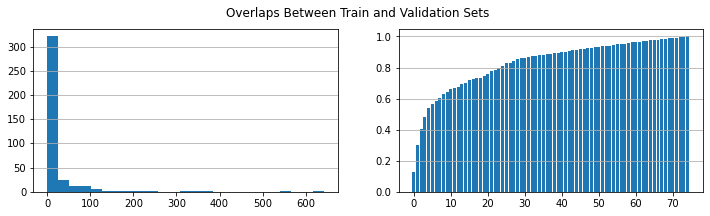

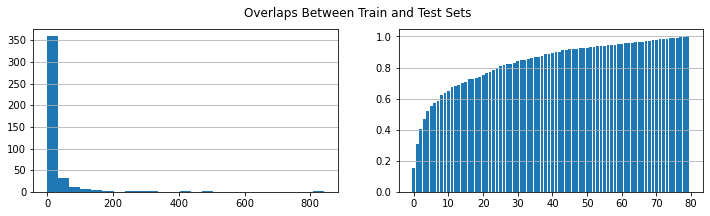

Looking for overlapping exact pairs:
Train/Val: ['Synaptics Inc|Atmel Corp']
Train/Test: ['Suzhou Dongshan Precision Manufacturing Co Ltd|Shenzhen Sunway Communication Co Ltd', 'Synaptics Inc|Atmel Corp'] 


Entropy: Stanford
       entropy_entity1  entropy_entity2  entropy_pair
count           585.00           620.00       5869.00
mean              0.04             0.41          0.00
std               0.16             0.38          0.02
min               0.00             0.00          0.00
25%               0.00             0.00          0.00
50%               0.00             0.45          0.00
75%               0.00             0.69          0.00
max               1.10             1.10          1.04


In [10]:
overlap_val_count, overlap_val_summary, overlap_test_count, overlap_test_summary = overlap_analysis_fn(stan_train, stan_val, stan_test, 'Stanford')

In [11]:
overlap_val_count[:10], overlap_val_summary

([('Samsung Electronics Co Ltd', 642),
  ('Boeing Co', 562),
  ('SoftBank Group Corp', 377),
  ('Comcast Corp', 334),
  ('Uber Technologies Inc', 320),
  ('Oracle Corp', 236),
  ('Charter Communications Inc', 225),
  ('Time Warner Inc', 190),
  ('Intel Corp', 173),
  ('ZTE Corp', 137)],
 count    388.000000
 mean      22.216495
 std       59.844800
 min        0.000000
 25%        1.000000
 50%        4.000000
 75%       20.000000
 max      642.000000
 dtype: float64)

In [12]:
overlap_test_count[:10], overlap_test_summary

([('Amazon.com Inc', 841),
  ('Verizon Communications Inc', 486),
  ('Alphabet Inc', 478),
  ('Tesla Inc', 413),
  ('Lockheed Martin Corp', 328),
  ('Netflix Inc', 284),
  ('Apple Inc', 263),
  ('Walmart Inc', 258),
  ('Boeing Co', 257),
  ('Federal Aviation Administration', 191)],
 count    423.000000
 mean      23.619385
 std       67.134719
 min        0.000000
 25%        1.000000
 50%        4.000000
 75%       21.000000
 max      841.000000
 dtype: float64)